## Measuring Market Sentiment: Analyzing Reddit Discussions, Search Interest, and Stock Performance 

In this project, I seek to answer the following question:
How can Reddit sentiment toward stock tickers be quantitatively analyzed, and what does it reveal about current market discussion trends?

I am using Python to scrape posts and comments from subreddits including r/wallstreetbets, r/stocks, and r/investing that mention stock tickers. By collecting and analyzing the sentiment expressed in Reddit comments, I aim to identify general positive or negative trends within the stocks movements.

In [2]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import praw
import matplotlib.pyplot as plt
import math
import datetime as dt
import pandas as pd
import numpy as np
import yfinance as yf

# download sentiment analysis lexicon
nltk.download('vader_lexicon')
nltk.download('stopwords')

# initialize reddit api credentials
reddit = praw.Reddit(
    client_id="VDKJ3wny9uRs-x37_mwxOA",
    client_secret="nL5FIo5h5cdGxI-PG1c5obdTHm_HwA",
    user_agent="my_scraper/0.1 by chemical_enjoyer"
)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jacks\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jacks\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# These are the stocks I decided to look at for this project.

# I tried to go for a diverse list with recently popular stocks
# like PLTR, NVDA, AMD, and stocks that have been historically
# driven by social media like GME and AMC.

# used a list of tuples to broaden my search query to include the ticker and full company name
stocks = [
    ("TSLA", "Tesla"),
    ("PLTR", "Palantir"),
    ("GME", "GameStop"),
    ("AMC", "AMC Entertainment"),
    ("NVDA", "Nvidia"),
    ("AMD", "Advanced Micro Devices"),
    ("MSFT", "Microsoft"),
    ("AAPL", "Apple"),
    ("META", "Meta Platforms")
]

#### Collecting Reddit Data

Below is the code I developed to scrape reddit comments. I utilized the Reddit API through the [praw](https://praw.readthedocs.io/en/stable/) library. My functions search reddit for mentions of the ticker or company name and collect meta data on the comments including, number of comments, net karma (upvotes - downvotes), post domain, author, and timestamp. 

This provides a foundation of raw data about the posts where these stocks are being discussed.

#### Sentiment Analysis

To analyze the sentiment of these comments I used the [VADER SentimentIntensityAnalyzer (SIA)](https://github.com/cjhutto/vaderSentiment) to score each comment:

- Positive sentiment comments are assigned +1
- Negative sentiment comments are assigned -1
- Neutral or unclear comments are scored 0

Then I calculate an average sentiment score per post based on the individual comments sentiment score.

In [4]:
# Helper functions

def commentSentiment(ticker, URL):
    # Takes the ticker and reddit url, 
    # analyzes the sentient of all comments and returns the average sentiment score

    # empty lists to hold comments
    subComments = []
    bodyComment = []
    
    try:
        check = reddit.submission(url=URL)  # get the reddit submission aka post
        subComments = check.comments  # get all top-level comments
    except:
        return 0  # return 0 if post cannot be accessed, using zeros for error handling later
    
    for comment in subComments:
        try:
            bodyComment.append(comment.body)  # Extract comment text
        except:
            return 0  # return 0 if comment body cannot be accessed
    
    sia = SIA()  # initialize SentimentIntensityAnalyzer
    results = []
    
    # analyze sentiment for each comment
    for line in bodyComment:
        scores = sia.polarity_scores(line)
        scores['headline'] = line  # keep the original comment text
        results.append(scores)
    
    df = pd.DataFrame.from_records(results)  # make results a dataframe
    df['label'] = 0  # create a label column
    
    try:
        # label comments as positive: 1, negative: -1, or neutral: 0 based on the compound score
        df.loc[df['compound'] > 0.1, 'label'] = 1
        df.loc[df['compound'] < -0.1, 'label'] = -1
    except:
        return 0  # 0 if label assignment fails
    
    # calcualte average sentiment label across all comments
    averageScore = 0
    position = 0

    while position < len(df.label) - 1:
        averageScore += df.label[position]
        position += 1

    averageScore = averageScore / len(df.label)
    
    return averageScore

In [5]:
# main code to collect Reddit post statistics

# How many posts to look for
# I used 1000 which takes about an hour to run, so I set it as 1 to demonstrate (this will not find very much data)
LIMIT = 1

post_statistics = []

# loop through our list of tickers
for ticker in stocks:
    # search the wallstreetbets, investing, and stocks sub reddits for the ticker or the compnay name
    for post in reddit.subreddit('wallstreetbets+investing+stocks').search(f"{ticker[0]} OR {ticker[1]}", limit=LIMIT):
        data = {} # collect post data in a dictionary
        data['ticker'] = ticker[0]
        data['num_comments'] = post.num_comments 
        data['comment_sentiment_average'] = commentSentiment(ticker[0], post.url)  # get the average sentiment of comments
        
        if data['comment_sentiment_average'] == 0.0:
            # skip if sentiment analysis failed or no comments, failure usually results in 0 float because of error handling before
            continue  
        
        data['timestamp'] = post.created_utc
        data['score'] = post.score  # karma score (upvotes - downvotes)
        data['upvote_ratio'] = post.upvote_ratio  # ratio of upvotes to total votes
        data['domain'] = post.domain  
        data['author'] = post.author  
        
        post_statistics.append(data)  # add data to the list

# make statistics into a DataFrame
sentiment = pd.DataFrame(post_statistics)

# make timestamps readable
sentiment['timestamp'] = pd.to_datetime(sentiment['timestamp'], unit='s')

# sort by date
sentiment.sort_values("timestamp", axis=0, ascending=True, inplace=True, na_position='last')

sentiment = sentiment.reset_index(drop=True)

# sentiment.to_csv('Reddit_Sentiment.csv', index=False) 

sentiment

,ticker,num_comments,comment_sentiment_average,timestamp,score,upvote_ratio,domain,author
0,AMC,398,0.105263,2020-04-29 01:52:12,2077,0.98,self.stocks,ledgendary
1,META,155,-0.054054,2024-11-28 14:25:22,1067,0.88,self.stocks,caollero
2,AMD,422,0.100000,2025-01-05 19:39:21,593,0.90,self.wallstreetbets,One-Hovercraft-1935


In [6]:
# Here I prepare my reddit data to be merged with stock price data grouping by timestamp

# read in the data pulled from the reddit api, again just doing this because it takes up to an hour to pull
reddit_df = pd.read_csv('Reddit_Sentiment.csv')

# Convert timestamps
reddit_df['timestamp'] = pd.to_datetime(reddit_df['timestamp'])

# Group by date and ticker
daily_sentiment = reddit_df.groupby([reddit_df['timestamp'].dt.date, 'ticker']).agg({
    'comment_sentiment_average': 'mean',
    'num_comments': 'sum',
    'score': 'mean',
    'upvote_ratio': 'mean'
}).reset_index()

# Now 'daily_sentiment' is ready to join with daily stock data
daily_sentiment

,timestamp,ticker,comment_sentiment_average,num_comments,score,upvote_ratio
0,2012-05-12,PLTR,0.500000,429,1213.0,0.97
1,2012-11-14,AMD,0.500000,4,7.0,0.83
2,2013-12-05,AMC,0.625000,46,34.0,0.81
3,2015-06-26,AMD,0.200000,13,0.0,0.50
4,2015-10-08,MSFT,0.341463,226,291.0,0.89
...,...,...,...,...,...,...
923,2025-04-25,TSLA,-0.018868,467,3843.0,0.97
924,2025-04-26,AAPL,0.303030,271,1631.0,0.98
925,2025-04-26,META,0.187500,82,12.0,0.65
926,2025-04-27,META,0.333333,17,33.0,0.82


#### Retrieving and Preparing Stock Market Data

I collected historical stock data using the yfinance library to compare with the reddit sentiment dataset.

I added key metrics to the data such as daily return, the percentage change from the opening to the closing price, and calculated the future 5-day average daily return, which estimates the short term expected return by averaging the next five days of daily returns. This allows us to see how the sentiment may predict future impacts on the market.

In [7]:
# use the min and max dates found in the reddit sentiment data for our time frame
min_date = str(daily_sentiment['timestamp'].min())[:8] + '01'
max_date = str(daily_sentiment['timestamp'].max())[:10]

# get all unique tickers, using this instead in case no comments are found for a ticker
tickers = list(daily_sentiment['ticker'].unique())

stock_data = yf.download(tickers, start=min_date, end=max_date, group_by='ticker')

d = []
# clean the multi ticker data into a single df with timestamp and ticker as columns
for ticker in tickers:
    df = stock_data[ticker].copy()
    df['ticker'] = ticker
    df['timestamp'] = df.index
    d.append(df)

stock_data = pd.concat(d).reset_index(drop=True)

# reorder columns
stock_data = stock_data[['timestamp', 'ticker', 'Open', 'High', 'Low', 'Close', 'Volume']]

# calculate daily return
stock_data['daily_return'] = (stock_data['Close'] - stock_data['Open']) / stock_data['Open']

stock_data = stock_data.sort_values(['ticker', 'timestamp'])

# calculate future 5-day average daily return
stock_data['future_5day_avg_return'] = (
    stock_data.groupby('ticker')['daily_return']
    .transform(lambda x: x.shift(-1).rolling(window=5, min_periods=1).mean()) # window 5 days, shift -1 starts the next day
)

stock_data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  9 of 9 completed


Price,timestamp,ticker,Open,High,Low,Close,Volume,daily_return,future_5day_avg_return
13064,2012-05-01,AAPL,17.601748,17.958657,17.491305,17.518389,610999200.0,-0.004736,0.009892
13065,2012-05-02,AAPL,17.461506,17.676976,17.419977,17.634243,427389200.0,0.009892,-0.002404
13066,2012-05-03,AAPL,17.770274,17.797358,17.463318,17.509060,390549600.0,-0.014699,-0.008436
13067,2012-05-04,AAPL,17.366416,17.404935,17.008001,17.010408,529992400.0,-0.020500,-0.002774
13068,2012-05-07,AAPL,16.897551,17.236705,16.889425,17.137697,460118400.0,0.014212,-0.002711
...,...,...,...,...,...,...,...,...,...
26123,2025-04-21,TSLA,230.259995,232.210007,222.789993,227.500000,97768000.0,-0.011986,0.000414
26124,2025-04-22,TSLA,230.960007,242.789993,229.850006,237.970001,120858500.0,0.030352,-0.006180
26125,2025-04-23,TSLA,254.860001,259.450012,244.429993,250.740005,150381900.0,-0.016166,0.005908
26126,2025-04-24,TSLA,250.500000,259.540009,249.199997,259.510010,94464200.0,0.035968,0.025410


In [8]:
# make sure timestamps are datetime
daily_sentiment['timestamp'] = pd.to_datetime(daily_sentiment['timestamp'])
stock_data['timestamp'] = pd.to_datetime(stock_data['timestamp'])

# merge sentiment and stock data
merged_df = pd.merge(daily_sentiment, stock_data, on=['timestamp', 'ticker'], how='inner')

merged_df

,timestamp,ticker,comment_sentiment_average,num_comments,score,upvote_ratio,Open,High,Low,Close,Volume,daily_return,future_5day_avg_return
0,2012-11-14,AMD,0.500000,4,7.0,0.83,2.040000,2.050000,1.920000,1.930000,40052600.0,-0.053922,-0.007793
1,2013-12-05,AMC,0.625000,46,34.0,0.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-06-26,AMD,0.200000,13,0.0,0.50,2.540000,2.550000,2.370000,2.470000,97054200.0,-0.027559,-0.013599
3,2015-10-08,MSFT,0.341463,226,291.0,0.89,40.712578,41.552011,40.660112,41.490803,33772700.0,0.019115,0.006776
4,2016-03-30,AMD,0.136364,56,187.0,0.95,2.880000,2.980000,2.850000,2.860000,14945900.0,-0.006945,0.013374
...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,2025-04-22,TSLA,0.010104,426,495.5,0.96,230.960007,242.789993,229.850006,237.970001,120858500.0,0.030352,-0.006180
704,2025-04-24,AAPL,0.172414,92,862.0,0.98,204.889999,208.830002,202.940002,208.369995,47311000.0,0.016985,0.008436
705,2025-04-24,META,0.333333,4,43.0,0.88,518.729980,533.900024,517.500000,533.150024,13910000.0,0.027799,0.003311
706,2025-04-24,PLTR,0.166667,186,225.0,0.80,101.529999,108.000000,100.910004,107.779999,103190700.0,0.061558,0.022734


#### Correlation Between Reddit Sentiment and Stock Returns

To see how reddit sentiment is related to stock price movements I calculated the correlation between the average comment sentiment for each ticker and its future 5 day average daily return.

#### Interpretations

- For most stocks, the correlation between sentiment and future returns is positive  but weak around 15%. This suggests that positive sentiment is associated with slightly better short term returns for these stocks.

- However, for PLTR (-0.1029), META (-0.0606), and TSLA (-0.1419), the correlation is negative, meaning that more positive sentiment was actually associated with slightly worse short-term returns for these stocks.

- MSFT (0.0212) shows almost no correlation, implying that my sentiment data has little predictive power for Microsoft stock movements.

#### Scatter plot

The scatter plot visualizes the relationship between average Reddit sentiment (x-axis) and future 5-day average stock returns (y-axis) for individual posts.

- Most of the points cluster around a return of 0 indicating that Reddit sentiment is not strongly predictive of large positive or negative movements.

- There is a slight skew toward positive returns, suggesting that posts with slightly more positive sentiment may be associated with better stock performance.

If there were a strong correlation, we would expect to see points forming a clear diagonal pattern.

Overall, the scatter plot reinforces the earlier finding that Reddit sentiment shows only a weak relationship with future returns.
While positive sentiment may tilt outcomes slightly upward, other factors likely dominate stock performance over short periods.

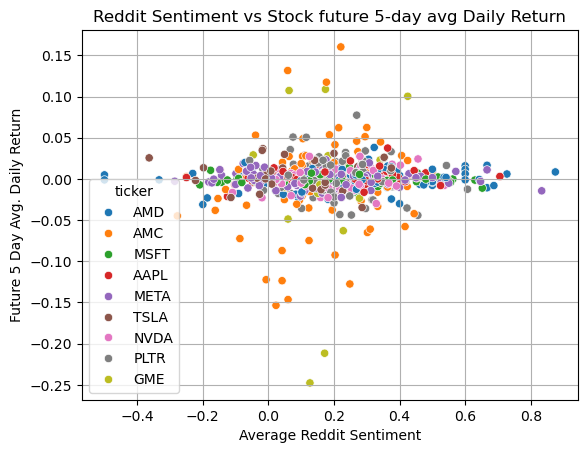

Correlation between sentiment and future 5-day avg daily return:
PLTR: -0.1029
AMD: 0.1564
AMC: 0.1422
MSFT: 0.0212
AAPL: 0.1504
NVDA: 0.1437
META: -0.0606
TSLA: -0.1419
GME: 0.1348


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x='comment_sentiment_average', y='future_5day_avg_return', hue='ticker', data=merged_df)
plt.title('Reddit Sentiment vs Stock future 5-day avg Daily Return')
plt.xlabel('Average Reddit Sentiment')
plt.ylabel('Future 5 Day Avg. Daily Return')
plt.grid(True)
plt.show()

# calculate and print corrilations for each ticker
print("Correlation between sentiment and future 5-day avg daily return:")
for ticker in tickers:
    ticker_df = merged_df[merged_df['ticker'] == ticker] # filter by ticker
    correlation = ticker_df['comment_sentiment_average'].corr(ticker_df['future_5day_avg_return'])
    print(f'{ticker}: {correlation:.4f}') # round corrilation to 4 decimals


#### Categorizing Sentiment: Bullish, Bearish, and Neutral
To better understand the distribution of sentiment in the Reddit data, I categorized each post into bullish, bearish, or neutral sentiment groups based on a simple threshold.

Specifically:

Posts with an average sentiment greater than 0.2 were labeled bullish.

Posts with an average sentiment less than -0.2 were labeled bearish.

Posts with an average sentiment between -0.2 and 0.2 were labeled neutral.

This allows for easier aggregation and visualization of how bullish, bearish, or neutral Reddit discussions are overall.

#### Visualization: Sentiment Distribution
To summarize the overall sentiment trends, I created a bar chart showing the total sum of sentiment scores in each category: bullish, bearish, and neutral.

The bar chart clearly shows that:

Bullish sentiment dominates the dataset, with significantly more positive sentiment posts than negative ones.

Neutral sentiment is the second most common, reflecting many discussions that express mixed or cautious views.

Bearish sentiment exists but represents a smaller share of the discussions.

This suggests that on Reddit, positive sentiment tends to outweigh negative sentiment when users discuss stocks, possibly reflecting an overall optimistic bias in retail investor communities. This also due to biases when calculating sediment, one example is the use of sarchasm which is very common on reddit where a user saying something bad about a stock sarcastically could be seen as positive sentiment. 



In [10]:
threshhold = 0.2

merged_df['sentiment_bullish'] = merged_df['comment_sentiment_average'].apply(lambda x: x if x > threshhold else 0)
merged_df['sentiment_bearish'] = merged_df['comment_sentiment_average'].apply(lambda x: x if x < -threshhold else 0)
merged_df['sentiment_neutral'] = merged_df['comment_sentiment_average'].apply(lambda x: x if -threshhold <= x <= threshhold else 0)
merged_df.head()

,timestamp,ticker,comment_sentiment_average,num_comments,score,upvote_ratio,Open,High,Low,Close,Volume,daily_return,future_5day_avg_return,sentiment_bullish,sentiment_bearish,sentiment_neutral
0,2012-11-14,AMD,0.500000,4,7.0,0.83,2.040000,2.050000,1.920000,1.930000,40052600.0,-0.053922,-0.007793,0.500000,0.0,0.000000
1,2013-12-05,AMC,0.625000,46,34.0,0.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.625000,0.0,0.000000
2,2015-06-26,AMD,0.200000,13,0.0,0.50,2.540000,2.550000,2.370000,2.470000,97054200.0,-0.027559,-0.013599,0.000000,0.0,0.200000
3,2015-10-08,MSFT,0.341463,226,291.0,0.89,40.712578,41.552011,40.660112,41.490803,33772700.0,0.019115,0.006776,0.341463,0.0,0.000000
4,2016-03-30,AMD,0.136364,56,187.0,0.95,2.880000,2.980000,2.850000,2.860000,14945900.0,-0.006945,0.013374,0.000000,0.0,0.136364


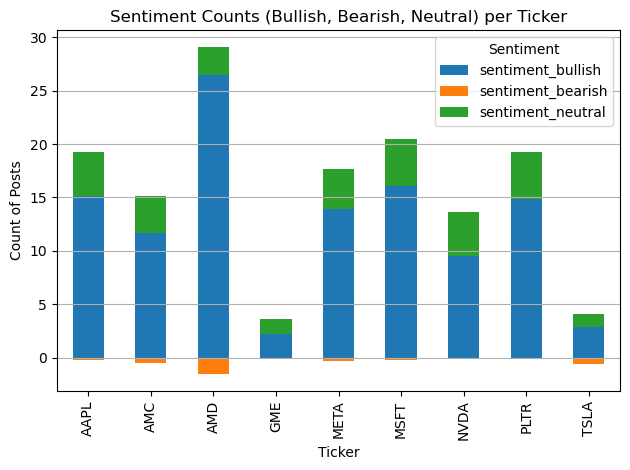

In [11]:
# group by the ticker and sum 
sentiment_counts = merged_df.groupby('ticker')[['sentiment_bullish', 'sentiment_bearish', 'sentiment_neutral']].sum()

# create stacked bar plot
sentiment_counts.plot(kind='bar', stacked=True)
plt.title('Sentiment Counts (Bullish, Bearish, Neutral) per Ticker')
plt.xlabel('Ticker')
plt.ylabel('Count of Posts')
plt.legend(title='Sentiment')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


#### Visualization: Individual Stock Sentiment vs Stock Price Over Time

To dive deeper I wanted to look at the rolling average of an individual stock's Reddit sentiment alongside its closing stock price over time. I chose to look at Apple in this example as it had the highest correlation to the future 5-day daily return, but I made the function dynamic to play around with the different tickets as well.

**Insights:**
- One notable pattern is that significant peaks in Apple's stock price tend to coincide with sharp changes in Reddit sentiment, either strong increases or strong drops.When Apple's stock price reaches a new high, Reddit sentiment often becomes much more polarized, swinging sharply up or down.
- This suggests that major price movements trigger reactions among online investors, leading to a surge in excitement or skepticism.

**Takeaways:** <br>
Although sentiment does not always move perfectly with stock price, sharp sentiment reactions often signal important market moments for Apple. <br>
Tracking sentiment could therefore help identify periods when retail investor emotions are  high, potentially foreshadowing greater volatility (market fluctuations).


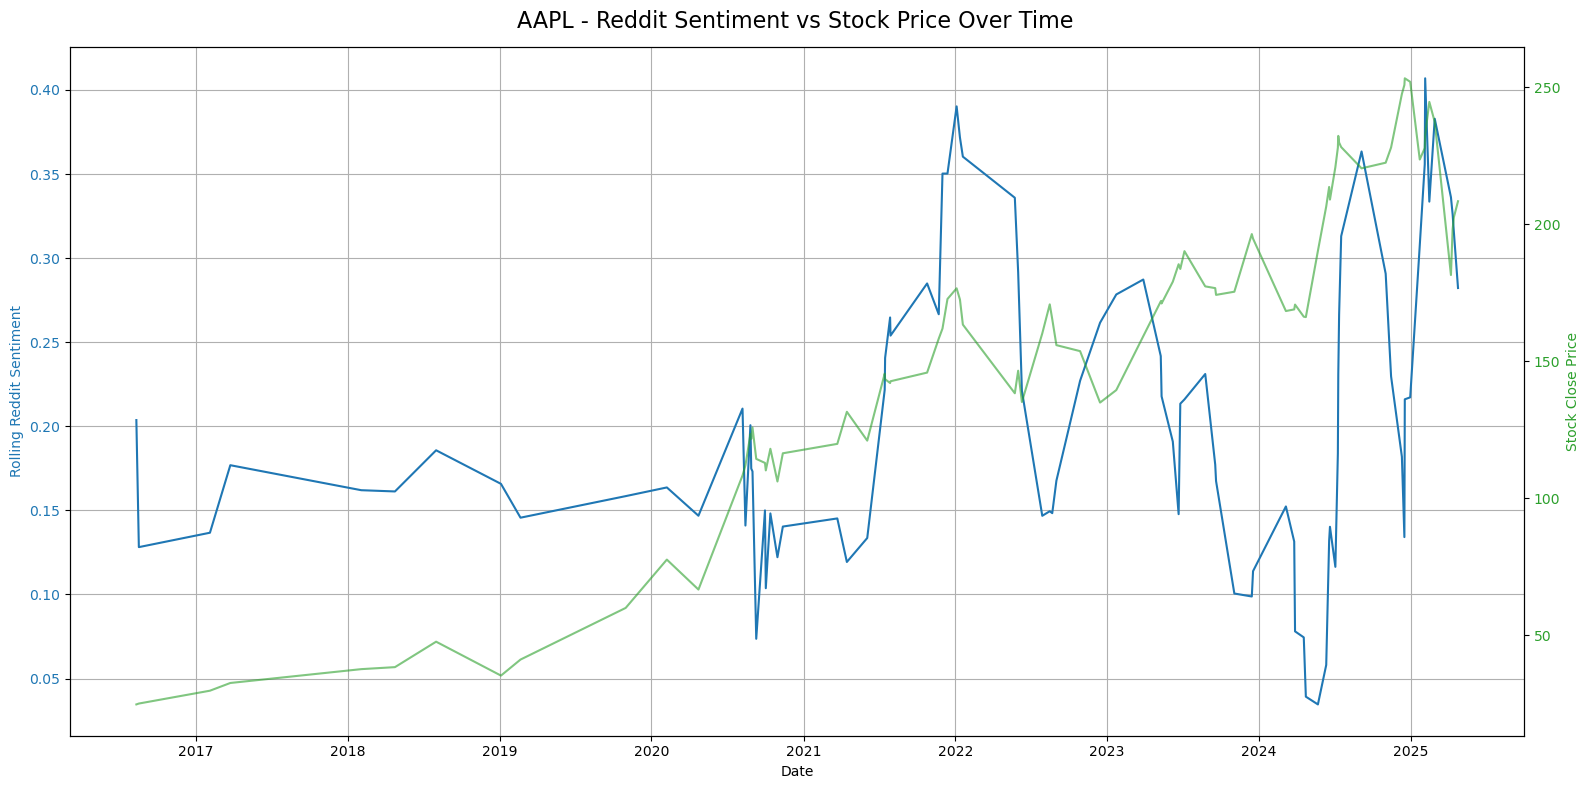

In [12]:
def rolling_average_plot(ticker, window_size):
    # make sure its sorted by timestamp and filter for given ticker
    df = merged_df[merged_df['ticker'] == ticker].sort_values('timestamp')

    # group by date and get daily average sentiment
    daily_sentiment = df.groupby('timestamp')['comment_sentiment_average'].mean().reset_index()

    # get rolling sentiment for window size
    daily_sentiment['rolling_sentiment'] = daily_sentiment['comment_sentiment_average'].rolling(window=window_size, min_periods=1).mean()

    # Also prepare stock Close prices (already available)
    stock_price = df[['timestamp', 'Close']].drop_duplicates()

    fig, ax1 = plt.subplots(figsize=(16,8))

    # plot rolling sentiment on left axis
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Rolling Reddit Sentiment', color=color)
    ax1.plot(daily_sentiment['timestamp'], daily_sentiment['rolling_sentiment'], color=color, label='Rolling Sentiment')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)

    # Create a second y-axis for stock price
    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Stock Close Price', color=color)
    ax2.plot(stock_price['timestamp'], stock_price['Close'], color=color, label=f'{ticker} Stock Price', alpha=0.6)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.suptitle(f'{ticker} - Reddit Sentiment vs Stock Price Over Time', fontsize=16)
    fig.tight_layout()
    plt.show()

rolling_average_plot('AAPL', 5)

### Integrating Google Trends Data with Reddit Sentiment
I incorporated Google Trends search interest data for each stock ticker.
This allows me to compare public search behavior with Reddit sentiment and stock performance, providing a deeper picture of investor attention.

I downloaded CSV for each of the tickers for 5 years of daily search interest data and merged this with my sentiment and market data.

Google Trends captures how much people are searching for a stock, offering a proxy for attention outside of Reddit. This lets us look at:

- How a surge in search interest predict changes in sentiment.

- If higher search interest correlate with price volatility.


In [13]:
# get and clean google trends data for each ticker
def get_trends(ticker, sentiment):
    # load csv
    trends = pd.read_csv(f'google_trends_{ticker.lower()}.csv',skiprows=1)

    # get the min date for the given ticker, starting at the first
    min_date = str(sentiment[sentiment['ticker'] == ticker]['timestamp'].min())[0:7] + "-01"

    # rename columns 
    trends.columns = ['timestamp', 'search_interest']

    # convert to datetime
    trends['timestamp'] = pd.to_datetime(trends['timestamp'])

    # filter to start at the min date
    trends_clean = trends[trends['timestamp'] >= min_date].reset_index(drop=True)

    # make timestamps datetime format and normalize to remove the time part
    trends_clean['timestamp'] = pd.to_datetime(trends_clean['timestamp'])
    trends_clean['timestamp'] = trends_clean['timestamp'].dt.normalize()

    return trends_clean

# create a copy of the merged_df
sentiment = merged_df.copy()

# get the tickers
tickers = list(sentiment['ticker'].unique())

# make sure sorted by date
sentiment = sentiment.sort_values('timestamp')

merged_list = []

# loop through each ticker
for ticker in tickers:
    # filter sentiment for the ticker first
    sentiment_ticker = sentiment[sentiment['ticker'] == ticker].sort_values('timestamp')

    # get trends data for the ticker
    trends = get_trends(ticker, sentiment)
    trends = trends.sort_values('timestamp') 

    # merge ticker specific sentiment with its trends
    merged_ticker  = pd.merge_asof(sentiment_ticker, trends, on='timestamp', direction='nearest')
    
    merged_list.append(merged_ticker)

# concatenate merged data together
google_trends_merged = pd.concat(merged_list).reset_index(drop=True)

# clean search interests, some are '<1' strings which causes errors when analyzing
google_trends_merged['search_interest'] = google_trends_merged['search_interest'].replace('<1', 0).astype(float)      

google_trends_merged.head()

,timestamp,ticker,comment_sentiment_average,num_comments,score,upvote_ratio,Open,High,Low,Close,Volume,daily_return,future_5day_avg_return,sentiment_bullish,sentiment_bearish,sentiment_neutral,search_interest
0,2012-11-14,AMD,0.500000,4,7.0,0.83,2.04,2.05,1.92,1.93,40052600.0,-0.053922,-0.007793,0.500000,0.0,0.000000,30.0
1,2015-06-26,AMD,0.200000,13,0.0,0.50,2.54,2.55,2.37,2.47,97054200.0,-0.027559,-0.013599,0.000000,0.0,0.200000,30.0
2,2016-03-30,AMD,0.136364,56,187.0,0.95,2.88,2.98,2.85,2.86,14945900.0,-0.006945,0.013374,0.000000,0.0,0.136364,30.0
3,2016-10-11,AMD,0.222222,23,6.0,0.67,6.80,6.84,6.38,6.50,32510800.0,-0.044118,-0.006610,0.222222,0.0,0.000000,30.0
4,2016-11-10,AMD,0.333333,10,1.0,1.00,6.82,6.91,6.22,6.30,71749500.0,-0.076246,0.002808,0.333333,0.0,0.000000,30.0


##### Correlation Between Search Interest and Stock Returns

First I looked at whether Google search interest for each stock ticker correlates with the stock’s future 5-day average daily return.

- For most stocks, the correlation between search interest and future returns is negative.

- Notably, stocks like AMC (-0.3366), MSFT (-0.2760), and GME (-0.2186) show a relatively stronger negative correlation.

- Overall, higher search interest tends to be associated with weaker future returns.

This pattern suggests that when investors start searching for a stock more frequently it may happen after major events not before them.

This insight aligns with the idea of this article: ["buy the rumor, sell the news"](https://www.investopedia.com/terms/n/news-trader.asp), where public attention peaks after the largest gains have already been made.

In [14]:
# calculate and print corrilations between search interest and future 5 day avg daily return, like before
print("Correlation between search interest and future 5 day average daily return:")
for ticker in tickers:
    ticker_df = google_trends_merged[google_trends_merged['ticker'] == ticker]
    correlation = ticker_df['search_interest'].corr(ticker_df['future_5day_avg_return'])
    print(f'{ticker}: {correlation:.4f}')


Correlation between search interest and future 5 day average daily return:
AMD: -0.0180
AMC: -0.3366
MSFT: -0.2760
AAPL: -0.0940
META: -0.1621
TSLA: -0.0826
NVDA: -0.1788
PLTR: 0.0345
GME: -0.2186


### Correlation Between Search Interest and Reddit Sentiment

I took a closer look at AMC, which had the lowest correlation -34% between Google search interest and future 5-day stock returns among all the tickers analyzed. To better understand this, I visualized the relationship between AMC's search interest and Reddit sentiment from 2020 to 2025.

Using a dual-axis time series plot: 
- The blue line shows Google search interest for AMC over time.
- The red line shows a 5-day rolling average of Reddit sentiment.

**Insights:**

- Reddit sentiment sometimes surged even when search interest was declining particularly between 2022 and 2023. This suggests that active Reddit discussions were not always matched by wider public attention through Google searches.

- During the famous WallStreetBets driven short squeeze events (early 2021), there was a sharp and simultaneous surge in both Reddit sentiment and search interest.

- After these major spikes, Reddit sentiment remained high while search interest decreased.

These insights align with the moderate negative correlation observed earlier between search interest and future returns for AMC.


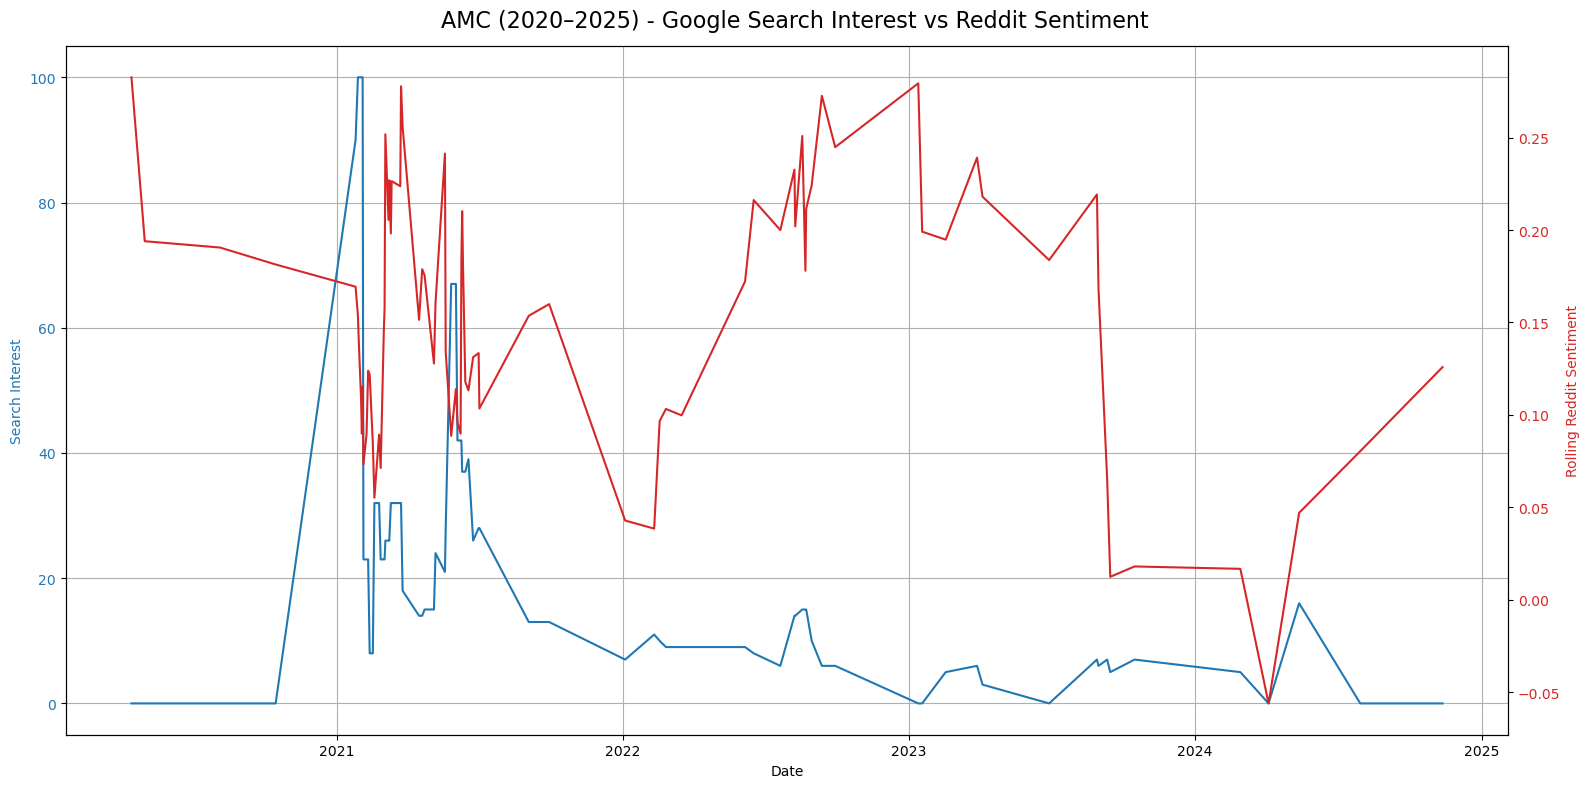

In [15]:
# plot Google search interest vs rolling Reddit sentiment for a specific stock ticker

def plot_search_vs_sentiment(ticker, data, rolling_window=5):
    """
    ,
    filtered between 2020 and 2025.

    Parameters:
    ticker (str): The stock ticker to plot (e.g., 'AAPL').
    data (DataFrame): The merged DataFrame containing timestamp, ticker, sentiment, and search interest.
    rolling_window (int): Window size for smoothing sentiment.
    """
    
    # Filter data between 2020 and 2025, because thats the google trends data we have
    ticker_df = data[
        (data['ticker'] == ticker) &
        (data['timestamp'] >= '2020-01-01') &
        (data['timestamp'] <= '2025-01-01')
    ].sort_values('timestamp').copy()
    
    # get rolling sentiment
    ticker_df['rolling_sentiment'] = ticker_df['comment_sentiment_average'].rolling(window=rolling_window, min_periods=1).mean()
    
    
    fig, ax1 = plt.subplots(figsize=(16,8))

    # plot search interest
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Search Interest', color=color)
    ax1.plot(ticker_df['timestamp'], ticker_df['search_interest'], color=color, label='Search Interest')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)

    # second y-axis for sentiment
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Rolling Reddit Sentiment', color=color)
    ax2.plot(ticker_df['timestamp'], ticker_df['rolling_sentiment'], color=color, label='Rolling Sentiment')
    ax2.tick_params(axis='y', labelcolor=color)

    # title and layout
    fig.suptitle(f'{ticker} (2020–2025) - Google Search Interest vs Reddit Sentiment', fontsize=16)
    fig.tight_layout()
    plt.show()

plot_search_vs_sentiment('AMC', google_trends_merged)


# Visualization: Search Interest vs Stock Price Volatility

To investigate how public attention impacts stock price movement, I created a scatter plot comparing Google search interest with daily stock price volatility.

- Volatility was calculated as the difference between each day's high and low stock prices.

- Search interest represents the relative frequency of searches for each stock, collected from Google Trends.

**Insights:**<br>
- The majority of data points are concentrated where volatility is between 0 and 50 dollars.

- As search interest increases, volatility slightly trends upwards as well, but the points become more sparse at higher levels of search interest.

- This pattern suggests that most trading days have moderate volatility, regardless of search activity.

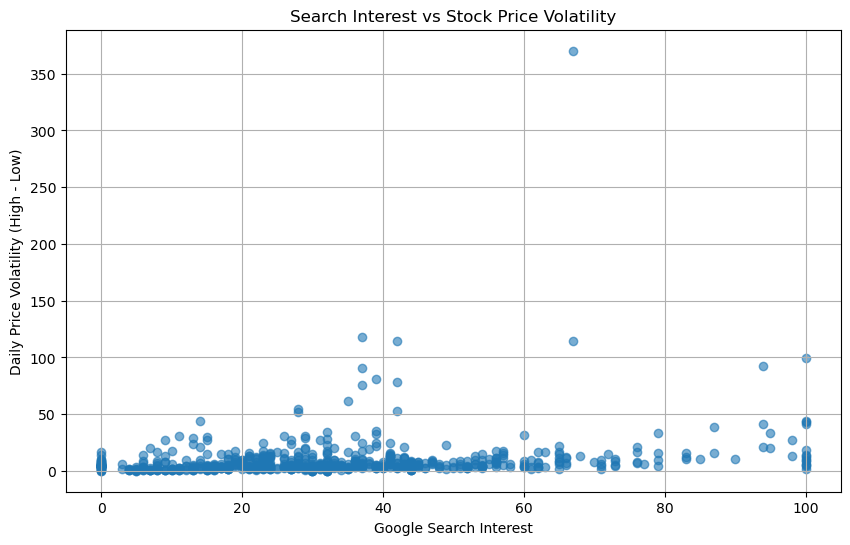

In [16]:
# scatter plot looking at seach interest vs price volatility

# calculate daily volatility
google_trends_merged['volatility'] = google_trends_merged['High'] - google_trends_merged['Low']

plt.figure(figsize=(10,6))
plt.scatter(google_trends_merged['search_interest'], google_trends_merged['volatility'], alpha=0.6)
plt.xlabel('Google Search Interest')
plt.ylabel('Daily Price Volatility (High - Low)')
plt.title('Search Interest vs Stock Price Volatility')
plt.grid(True)
plt.show()

#### Conclusion

This project demonstrates that Reddit sentiment and Google search interest can provide meaningful, although limited, predictions about stock market behavior.

While Reddit sentiment shows a general slight positive association with short-term stock returns, the strength of this relationship is mild. For most tickers analyzed, positive Reddit sentiment was correlated with slightly better future 5-day returns, but the effect was small and inconsistent across stocks. Stocks like TSLA and PLTR even showed a mild negative relationship between sentiment and future returns, highlighting that social media hype does not always translate directly into market gains.

Google Trends search interest, on the other hand, showed moderate negative correlation with future stock returns for several stocks, especially heavily discussed names on social media like AMC and GME. This suggests that spikes in public attention often occur after major price movements, consistent with the "buy the rumor, sell the news" phenomenon where retail attention chases already inflated prices rather than predicting future price increases.

Overall, the data suggests that while social media sentiment and public search interest can offer valuable context, they are not standalone predictors of stock performance.

In the future, working with more detailed and much larger sentiment data may yield greater correlation with market movements, and could be a strong  signal to trade with. Additionally, exploring more sophisticated natural language processing (NLP) techniques could help better distinguish between genuine sentiment and sarcasm, which is very prevalent in Reddit data.

